In [131]:
import numpy as np
import scipy.misc
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
import scipy.misc
import os
import warnings
warnings.filterwarnings("ignore")

In [132]:
cascPath = "haarcascade_frontalface_default.xml"
# Create the haar cascade
faceCascade = cv2.CascadeClassifier(cascPath)


In [133]:
## read the dataset
full_face = []
full_labels = []
all_images = os.listdir('yalefaces')
for j in range(1,11):    # there are 15 different people in the dataset
    img_list = [filename for filename in all_images if filename.startswith('subject%.2d'%j)]
#     img_list = glob.glob('yalefaces/subject%.2d*'%j)
    face1 = np.zeros((len(img_list),64,64))
    for k,img in enumerate(img_list):
        I = scipy.misc.imread(os.path.join('yalefaces',img))
        #print(type(I))
        I = cv2.fastNlMeansDenoising(I, None, 9, 13)
        I = cv2.GaussianBlur(I, (5,5), 0)
        I = cv2.equalizeHist(I)
        faces = faceCascade.detectMultiScale(
            I,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(30, 30))
        x,y,h,w = faces[0]
        face1[k,...] = zoom(I[y:y+h,x:x+w],[64./h,64./w])
        
    labels = (j-1)*np.ones((11,))
    full_face.append(face1)
    full_labels.append(labels)
full_face = np.stack(full_face)    # contains the images of all faces
full_labels = np.stack(full_labels)   # contains the ID of all the faces
full_face = np.stack(full_face)    # contains the images of all faces
full_labels = np.stack(full_labels)   # contains the ID of all the faces

In [134]:
full_face = full_face/255 #normalise data

In [135]:
# divide the data into train and test
# pick 2 images from each dataset and put it into test set
train_set = np.zeros((full_face.shape[0],9,64,64))
test_set = np.zeros((full_face.shape[0],2,64,64))
train_labels = np.zeros((full_face.shape[0],9))
test_labels = np.zeros((full_face.shape[0],2))
for k in range(full_face.shape[0]):
    g = np.random.permutation(11)   # randomly select the 9 faces
    train_set[k,...] = full_face[k,g[:9],...]
    train_labels[k,...] = full_labels[k,g[:9]]
    test_set = full_face[:,g[9:],...]
    test_labels[k,...] = full_labels[k,g[9:]]

In [136]:
from skimage.feature import local_binary_pattern
train_set = np.reshape(train_set,[-1,64,64])
train_labels = np.reshape(train_labels,[-1,])
test_set = np.reshape(test_set,[-1,64,64])
test_labels = np.reshape(test_labels,[-1,])
train_feat = np.zeros_like(train_set)
test_feat = np.zeros_like(test_set)

for k in range(train_feat.shape[0]):
        train_feat[k,...] = local_binary_pattern(train_set[k,...],8,3)#,method='uniform')
for k in range(test_feat.shape[0]):
        test_feat[k,...] = local_binary_pattern(test_set[k,...],8,3)#,method='uniform')
print(np.amax(test_feat))

255.0


In [137]:
# set the number of grids in x and y direction
# divide the image into the specified number of grids
# for each grid compute the histogram with 64 bins
# concatenate the histogram from all grid regions to form a single feature
# now we have one feature vector per image
# Note that grid size and histogram bin sizes are variable
x_grid = 7
y_grid = 7
grid_size_x = train_feat.shape[1]//x_grid
grid_size_y = train_feat.shape[2]//y_grid
for k in range(train_feat.shape[0]):
    for x in range(x_grid):
        for y in range(y_grid):
            patch = train_feat[k,x*grid_size_x:(x+1)*grid_size_x,y*grid_size_y:(y+1)*grid_size_y]
            hist,_ = np.histogram(patch.reshape(-1),bins=64)
            if x==0 and y==0:
                patch_hist_list = hist
            else:
                patch_hist_list = np.concatenate([patch_hist_list,hist],0)
    if k==0:
        data_hist = patch_hist_list[np.newaxis,...]
    else:
        data_hist = np.concatenate([data_hist,patch_hist_list[np.newaxis,...]],0)
print(data_hist.shape)

grid_size_x = test_feat.shape[1]//x_grid
grid_size_y = test_feat.shape[2]//y_grid

for k in range(test_feat.shape[0]):
    for x in range(x_grid):
        for y in range(y_grid):
            patch = test_feat[k,x*grid_size_x:(x+1)*grid_size_x,y*grid_size_y:(y+1)*grid_size_y]
            hist,_ = np.histogram(patch.reshape(-1),bins=64)
            if x==0 and y==0:
                patch_hist_list = hist
            else:
                patch_hist_list = np.concatenate([patch_hist_list,hist],0)
    if k==0:
        test_data_hist = patch_hist_list[np.newaxis,...]
    else:
        test_data_hist = np.concatenate([test_data_hist,patch_hist_list[np.newaxis,...]],0)
print(test_data_hist.shape)

(90, 3136)
(20, 3136)


In [138]:
from sklearn.decomposition import PCA
pca = PCA(whiten=True)
train_feat = data_hist
test_feat = test_data_hist
print(train_feat.shape,test_feat.shape)
pca.fit(train_feat)

(90, 3136) (20, 3136)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

In [139]:
# select number of components which explain 99% of the data variance
n_components = np.argmin(np.cumsum(pca.explained_variance_ratio_)<=0.99)
print(n_components)
train_feat_pca = pca.transform(train_feat)
train_feat_pca = train_feat_pca[:,:n_components]
test_feat_pca = pca.transform(test_feat)
test_feat_pca = test_feat_pca[:,:n_components]
print(train_feat_pca.shape)

79
(90, 79)


In [140]:
import itertools
img_pair = []
img_full_pair = []
label_pair = []
for pair in itertools.combinations_with_replacement(range(train_feat_pca.shape[0]),2):
    img_pair.append(train_feat_pca[pair,:])
    img_full_pair.append(train_set[pair,:])
    label_pair.append(train_labels[pair,])
img_pair = np.stack(img_pair)
img_full_pair = np.stack(img_full_pair)
label_pair = np.stack(label_pair)
label_pair = (label_pair[:,0] == label_pair[:,1])
label_pair = label_pair*1

In [141]:
test_img_pair = []
test_label_pair = []
for pair in itertools.combinations_with_replacement(range(test_feat.shape[0]),2):
    test_img_pair.append(test_feat_pca[pair,...])
    test_label_pair.append(test_labels[pair,])
test_img_pair = np.stack(test_img_pair)
test_label_pair = np.stack(test_label_pair)
test_label_pair = (test_label_pair[:,0] == test_label_pair[:,1])
test_label_pair = test_label_pair*1

In [142]:
img_pair = np.abs(img_pair[:,0,...] - img_pair[:,1,...])
test_img_pair = np.abs(test_img_pair[:,0,...] - test_img_pair[:,1,...])

In [143]:
# shuffle the training data
g = np.random.permutation(img_pair.shape[0])
img_pair = img_pair[g,:]
label_pair = label_pair[g,]




In [144]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(8, 10), random_state=1)
clf.fit(img_pair,label_pair)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(8, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [145]:
print(clf.score(test_img_pair,test_label_pair))

0.8857142857142857


In [146]:
clf=DecisionTreeClassifier()
clf.fit(img_pair,label_pair)
print(clf.score(test_img_pair,test_label_pair))

0.919047619047619


In [147]:
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression()
clf.fit(img_pair,label_pair)
print(clf.score(test_img_pair,test_label_pair))

0.9095238095238095


In [148]:
from sklearn.svm import SVC
clf=SVC(kernel='rbf')
clf.fit(img_pair,label_pair)
print(clf.score(test_img_pair,test_label_pair))

0.780952380952381


In [149]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier()
clf.fit(img_pair,label_pair)
pred=clf.predict(test_img_pair)
print(clf.score(test_img_pair,test_label_pair))

0.9857142857142858


In [187]:
print(clf.score(img_pair,label_pair))

0.9926739926739927


In [151]:
pred

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1])

## Testing

In [167]:
import h5py

In [168]:
h5f = h5py.File('test.h5','r')

In [169]:
h5f.keys()

KeysView(<HDF5 file "test.h5" (mode r)>)

In [170]:
a = list(h5f.keys())
len(a)

120

In [172]:
## read the dataset
full_face = []
full_labels = []
img_list=[h5f[i] for i in a]
face1 = np.zeros((len(img_list),64,64))
for k,img in enumerate(img_list):
    I = np.array(img)#scipy.misc.imread(os.path.join('yalefaces',img))
    #print(type(I))
    I = cv2.fastNlMeansDenoising(I, None, 9, 13)
    I = cv2.GaussianBlur(I, (5,5), 0)
    I = cv2.equalizeHist(I)
    faces = faceCascade.detectMultiScale(
        I,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30))
    #print(k)
    #print(faces)
    try : 
        x,y,h,w = faces[0]
        face1[k,...] = zoom(I[y:y+h,x:x+w],[64./h,64./w])
    except : 
        x,y,h,w=[0,0,111,91]
        face1[k,...] = zoom(I[y:y+h,x:x+w],[64./h,64./w])
    
    


In [173]:
face1=face1/255.0

In [174]:
#LBP
test_data=face1
test_data_feat = np.zeros_like(test_data)

for k in range(test_data_feat.shape[0]):
        test_data_feat[k,...] = local_binary_pattern(test_data[k,...],8,3)#,method='uniform')
print(np.amax(test_data_feat))
print(test_data_feat.shape)

255.0
(120, 64, 64)


In [175]:
# set the number of grids in x and y direction
# divide the image into the specified number of grids
# for each grid compute the histogram with 64 bins
# concatenate the histogram from all grid regions to form a single feature
# now we have one feature vector per image
# Note that grid size and histogram bin sizes are variable
x_grid = 7
y_grid = 7

grid_size_x = test_data_feat.shape[1]//x_grid
grid_size_y = test_data_feat.shape[2]//y_grid

for k in range(test_data_feat.shape[0]):
    for x in range(x_grid):
        for y in range(y_grid):
            patch = test_data_feat[k,x*grid_size_x:(x+1)*grid_size_x,y*grid_size_y:(y+1)*grid_size_y]
            hist,_ = np.histogram(patch.reshape(-1),bins=64)
            if x==0 and y==0:
                patch_hist_list = hist
            else:
                patch_hist_list = np.concatenate([patch_hist_list,hist],0)
    if k==0:
        test_data_hist = patch_hist_list[np.newaxis,...]
    else:
        test_data_hist = np.concatenate([test_data_hist,patch_hist_list[np.newaxis,...]],0)
print(test_data_hist.shape)

(120, 3136)


In [176]:
test_feat_pca = pca.transform(test_data_hist)
test_feat_pca = test_feat_pca[:,:n_components]
print(test_feat_pca.shape)

(120, 79)


In [177]:
test_pairs = np.genfromtxt('image_pairs.csv', dtype=None, delimiter=',', names=True)
test_pairs[0]

(0, 155, 140)

In [178]:
ids=[]
image1=[]
image2=[]
test_img_pairs=[]
for i in range(len(test_pairs)) : 
    ids.append(test_pairs[i][0])
    image1.append(test_pairs[i][1])
    image2.append(test_pairs[i][2])
    pair=(a.index(str(test_pairs[i][1])),a.index((str(test_pairs[i][2]))))
    
    test_img_pairs.append(test_feat_pca[pair,:])
test_img_pairs = np.stack(test_img_pairs)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373


In [179]:
test_img_pairs = np.abs(test_img_pairs[:,0,...] - test_img_pairs[:,1,...])

In [183]:
pred=clf.predict(test_img_pairs)

In [185]:
pred.shape

(3540,)

In [186]:
with open('rf_submit.csv','w') as f : 
    f.write('Id,Expected\n')
    for i in range(len(test_pairs)) : 
        
        f.write(str(ids[i])+','+str(pred[i])+'\n')

In [95]:
test_data=h5f[a[22]]
test_data=np.array(test_data)

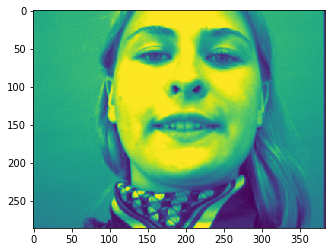

In [96]:
plt.imshow(test_data)

In [60]:
a

'100'